In [1]:
import requests, os, zipfile
import glob
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Path to the events archive
dataset_zip = '/tmp/events.zip'

# Path to the extracted events
dataset_dir = '/tmp/events/'

# Path to the dataset file
dataset_pkl = '/tmp/dataset.zip'

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#@title Dataset Download

import requests, os, zipfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Download the dataset
download_file_from_google_drive('1ZPgbhToHLXfLg2IPl0QkxgP6I1TI-KdU', dataset_zip)

# Unzip the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

In [3]:
# The dataframe of the events
events = pd.DataFrame()

# Get paths to the event files
pkl_paths = glob.glob(dataset_dir + '*.pkl')

# Concatenate the events
for pkl_path in pkl_paths:
  # Unpickle the event file
  pkl_file = open(pkl_path, 'rb')
  event = pk.load(pkl_file)

  # Create a dataframe for the event
  event = pd.DataFrame({'image': event[0], 'label': event[1]})

  # Concatenate the event
  events = pd.concat([events, event], axis=0)

# Save the dataset
events.to_pickle(dataset_pkl)

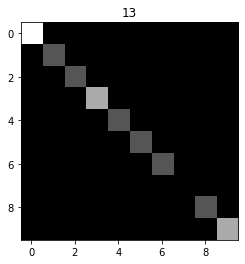

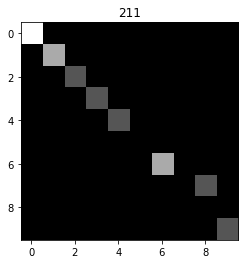

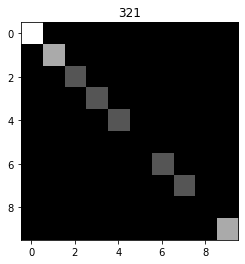

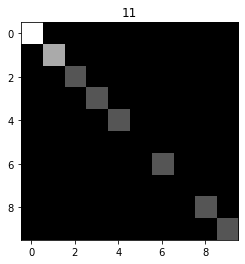

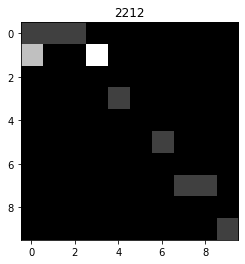

In [14]:
image_13 =  events[events['label']==13].iloc[1,0]
image_211 = events.iloc[1, 0]
image_321 = events.iloc[2,0 ]
image_11 = events[events['label']==11].iloc[1,0]
image_2212 = events[events['label']==2212].iloc[1,0]
lis = [image_13, image_211, image_321, image_11, image_2212]
tit = [13,211,321,11,2212]
for i,j in zip(tit,lis):
  plt.imshow(j, cmap='gray')
  plt.imsave('/tmp/{}.png'.format(i), j)
  plt.title(i)
  plt.show()

In [ ]:
np.diag(events.iloc[2,0])

array([3., 1., 1., 1., 1., 0., 1., 1., 0., 1.])

In [ ]:
df = events.copy()
df['diag'] = events['image'].apply(np.diag)

In [ ]:
df = df.drop(['image'], axis=1)
df=df.reindex(columns=['diag','label'])
df.head()

,diag,label
0,"[1.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",211
1,"[4.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",211
2,"[3.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",321
3,"[4.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...",211
4,"[5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, ...",211


In [ ]:
df['label'] = df['label'].apply(lambda x: 666 if x != 211 else x)
display(df)
encoder = LabelEncoder()

,diag,label
0,"[1.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",211
1,"[4.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",211
2,"[3.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",666
3,"[4.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...",211
4,"[5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, ...",211
...,...,...
3362,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",211
3363,"[4.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",211
3364,"[2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",666
3365,"[5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, ...",211


In [ ]:
df['label'] = encoder.fit_transform(df['label'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df['diag'].to_numpy()), df['label'].to_numpy())
df['label'].unique()

array([0, 1])

In [ ]:
clf_2 = RandomForestClassifier(class_weight='balanced')
clf_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf_2.score(X_test, y_test)


0.5600930235720916

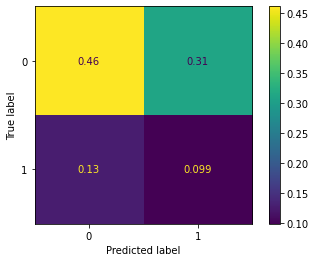

In [ ]:
plot_confusion_matrix(clf_2, X_test, y_test, normalize='all')

In [ ]:
for i in range(10):
  df[str(i)] = [x[i] for x in df.diag]
df.head()

In [ ]:
df = df.drop(['diag'], axis=1)
df.head()


,label,0,1,2,3,4,5,6,7,8,9
0,211,1.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
1,211,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,321,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
3,211,4.0,1.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,1.0
4,211,5.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0


In [ ]:
event_211 = events[events['label']==211]
event_211

,image,label
0,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",211
1,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",211
3,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",211
4,"[[5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",211
5,"[[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",211
...,...,...
3360,"[[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",211
3361,"[[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",211
3362,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",211
3363,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",211


In [ ]:
image_13 =  events[events['label']==13].iloc[1,0]
image_211 = events.iloc[1, 0]
image_321 = events.iloc[2,0 ]
image_11 = events[events['label']==11].iloc[1,0]
image_2212 = events[events['label']==2212].iloc[1,0]
lis = [image_13, image_211, image_321, image_11, image_2212]

In [ ]:
tit = [13,211,321,11,2212]

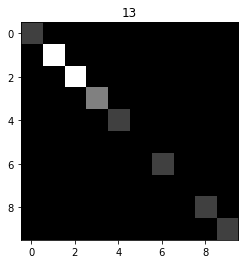

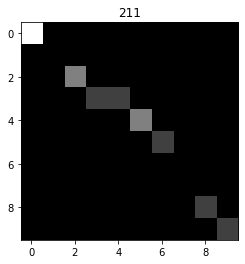

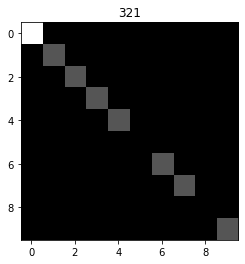

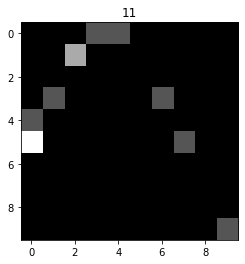

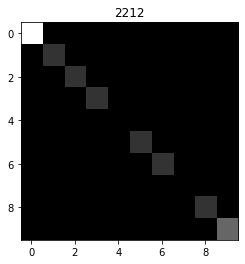

In [ ]:
for i,j in zip(tit,lis):
  plt.imshow(j, cmap='gray')
  plt.title(i)
  plt.show()

In [ ]:
def avg_matrix(matrix, num):
  class_13 = matrix[matrix['label']==num]
  class_13_avg_matrix = class_13['image'].to_numpy()
  class_13_avg_matrix = np.stack(class_13_avg_matrix, axis=0)
  class_13_avg_matrix = np.average(class_13_avg_matrix, axis=0)
  return class_13_avg_matrix

In [ ]:
def plot_im(image):
  plt.imshow(image,cmap='gray')
  plt.show()

In [ ]:
matrices = []

[]

In [ ]:
for i in tit:
  matrices.append(avg_matrix(events, i))
  #plot_im(avg_matrix(events, i))

In [ ]:
matrices

[array([[3.06224737e+00, 8.81164107e-02, 2.91026677e-02, 1.05092967e-02,
         9.70088925e-03, 0.00000000e+00, 6.46725950e-03, 4.04203719e-03,
         0.00000000e+00, 8.89248181e-03],
        [4.68876314e-02, 1.46079224e+00, 7.03314470e-02, 1.85933711e-02,
         3.23362975e-03, 0.00000000e+00, 4.04203719e-03, 8.08407437e-04,
         0.00000000e+00, 8.08407437e-04],
        [1.77849636e-02, 6.46725950e-03, 1.28779305e+00, 1.05092967e-01,
         1.13177041e-02, 0.00000000e+00, 3.23362975e-03, 1.61681487e-03,
         8.08407437e-04, 1.61681487e-03],
        [1.05092967e-02, 0.00000000e+00, 5.65885206e-03, 9.76556184e-01,
         6.30557801e-02, 0.00000000e+00, 5.65885206e-03, 2.42522231e-03,
         0.00000000e+00, 1.61681487e-03],
        [2.42522231e-03, 8.08407437e-04, 4.85044462e-03, 2.10185934e-02,
         8.41552142e-01, 4.28455942e-02, 1.29345190e-02, 5.65885206e-03,
         0.00000000e+00, 1.61681487e-03],
        [1.61681487e-03, 1.61681487e-03, 6.46725950e-03, 1.6

In [ ]:
avg_avg_matrices = np.average(matrices, axis = 0)

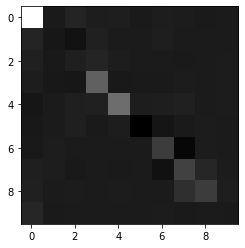

In [ ]:
plot_im(matrices[0]-avg_avg_matrices)

In [ ]:
mean = events['image'].mean()


In [ ]:
x = lambda x: x[0] - mean

In [ ]:
events_centered = events.copy()
encoder = LabelEncoder()
events_centered['image'] = events['image'].apply(lambda x: x - mean)
events_centered['label'] = encoder.fit_transform(events_centered['label'])

In [ ]:
events_centered['label'].value_counts()

2    906047
3    154323
4    111730
0      3138
1      1237
Name: label, dtype: int64

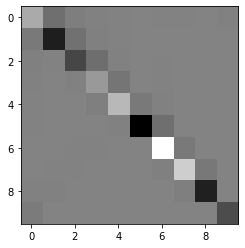

In [ ]:
plot_im(events_centered.iloc[2,0])

In [ ]:
X_train, x_test, y_train, y_test = train_test_split(np.stack(events_centered['image'].to_numpy(), axis=0).reshape(-1, 100), events_centered['label'].to_numpy())
#X_train = X_train#.to_numpy()
#y_train = y_train.to_numpy()
#x_test, y_test = x_test.to_numpy(), y_test.to_numpy()
#X_train.shape

(882356, 100)

In [ ]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf.score(x_test, y_test)

0.3091877777362224

In [ ]:
y_pred = clf.predict(x_test)
y_true = y_test
cm = confusion_matrix(y_true, y_pred)
accuracies = cm.diagonal()/cm.sum(axis=1)
print(accuracies)

[0.20156047 0.22255193 0.32855169 0.25914079 0.2254881 ]


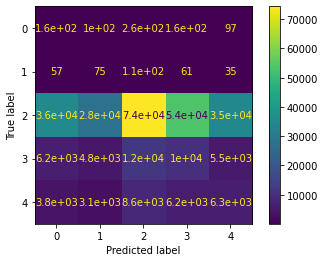

In [ ]:
plot_confusion_matrix(clf, x_test, y_test)
plt.show()  

In [ ]:
predictions = clf.predict(x_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test , predictions)

0.3091877777362224

In [ ]:
events.shape[0]
labels = events.label
classes = labels.unique()

In [ ]:
weights = compute_class_weight('balanced', classes, labels)
class_weigths = dict(zip(classes, weights))


{11: 74.98247291268324,
 13: 190.21422797089733,
 211: 0.2596940335324768,
 321: 1.524691718019997,
 2212: 2.1059249977624632}